# Import

In [1]:
from __future__ import division

from models import *
from utils.utils import *
from utils.datasets import *

import os
import sys
import time
import datetime
import argparse
import cv2

from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator


# Arg Parse

In [2]:
# parser = argparse.ArgumentParser()
# parser.add_argument("--image_folder", type=str, default="data/samples", help="path to dataset")
# parser.add_argument("--model_def", type=str, default="config/yolov3.cfg", help="path to model definition file")
# parser.add_argument("--weights_path", type=str, default="weights/yolov3.weights", help="path to weights file")
# parser.add_argument("--class_path", type=str, default="data/coco.names", help="path to class label file")
# parser.add_argument("--conf_thres", type=float, default=0.8, help="object confidence threshold")
# parser.add_argument("--nms_thres", type=float, default=0.4, help="iou thresshold for non-maximum suppression")
# parser.add_argument("--batch_size", type=int, default=1, help="size of the batches")
# parser.add_argument("--n_cpu", type=int, default=0, help="number of cpu threads to use during batch generation")
# parser.add_argument("--img_size", type=int, default=416, help="size of each image dimension")
# parser.add_argument("--checkpoint_model", type=str, help="path to checkpoint model")
# opt = parser.parse_args()
# print(opt)

In [3]:
class opt:
    image_folder = "data/samples"
    model_def = "config/yolov3.cfg"
    weights_path = "weights/yolov3.weights"
    class_path = "data/coco.names"
    conf_thres = 0.8
    nms_thres = 0.4
    batch_size = 1
    n_cpu = 0
    img_size = 416
    checkpoint_model= str()

In [4]:
def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

In [5]:
def figure_to_array(fig):
    """
    plt.figure를 RGBA로 변환(layer가 4개)
    shape: height, width, layer
    """
    fig.canvas.draw()
    return np.array(fig.canvas.renderer._renderer)

# Model Load

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output", exist_ok=True)

# Set up model
model = Darknet(opt.model_def, img_size=opt.img_size).to(device)

if opt.weights_path.endswith(".weights"):
    # Load darknet weights
    model.load_darknet_weights(opt.weights_path)
else:
    # Load checkpoint weights
    model.load_state_dict(torch.load(opt.weights_path))

model.eval()  # Set in evaluation mode

dataloader = DataLoader(
    ImageFolder(opt.image_folder, img_size=opt.img_size),
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.n_cpu,
)

classes = load_classes(opt.class_path)  # Extracts class labels from file

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

imgs = []  # Stores image paths
img_detections = []  # Stores detections for each image index

# Webcam Define

In [7]:
width = 1280
height = 720

cam = cv2.VideoCapture(0)
cam.set(3, width)
cam.set(4, height)

True

# Webcam

In [8]:
# Bounding-box colors
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

frames = 0
start = time.time()
plt.figure()

ret_val, img = cam.read()
img_size = img.shape[:2]

while True:
    ret_val, img = cam.read()
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Mirror 
    img = cv2.flip(img, 1)
    img_re = cv2.resize(img, (416, 416))
    
    input_imgs = transforms.ToTensor()(img_re)
    input_imgs = torch.unsqueeze(input_imgs, 0).cuda()

    # Get detections
    with torch.no_grad():
        detections = model(input_imgs)
        detections = non_max_suppression(detections, opt.conf_thres, opt.nms_thres)
        img_detections.extend(detections)
    
    
#     # Create plot
#     # img = np.array(Image.open(path))
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Draw bounding boxes and labels of detections
    if detections is not None:
        # Rescale boxes to original image
        detections = rescale_boxes(detections[0], opt.img_size, img.shape[:2])

#         unique_labels = detections[:, -1].cpu().unique()
#         n_cls_preds = len(unique_labels)
#         bbox_colors = random.sample(colors, n_cls_preds)
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

#             print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

            box_w = x2 - x1
            box_h = y2 - y1

#             color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            color = 'red'
            # Create a Rectangle patch
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
            # Add the bbox to the plot
            ax.add_patch(bbox)
            # Add label
            plt.text(
                x1,
                y1,
                s=classes[int(cls_pred)],
                color="white",
                verticalalignment="top",
                bbox={"color": color, "pad": 0},
            )

    # Save generated image with detections
    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())

    fig_img = figure_to_array(fig)
    
    plt.close()
    
    frames += 1
    intv = time.time() - start
    if intv > 1:
        print("FPS of the video is {:5.2f}".format( frames / intv ))
        print(detections)
        start = time.time()
        frames = 0
    
    cv2.imshow('Demo webcam', fig_img)
    if cv2.waitKey(1) == 27: 
        break  # esc to quit
        
cam.release()
cv2.destroyAllWindows()

FPS of the video is  0.80
tensor([[3.9433e+02, 2.1837e+01, 1.1771e+03, 1.0023e+03, 9.9686e-01, 9.9991e-01,
         0.0000e+00]])
FPS of the video is  9.38
tensor([[3.9736e+02, 1.6916e+01, 1.1745e+03, 1.0065e+03, 9.9705e-01, 9.9992e-01,
         0.0000e+00]])
FPS of the video is  9.45
tensor([[4.3047e+02, 8.2306e+01, 1.1515e+03, 9.8175e+02, 9.9542e-01, 1.0000e+00,
         0.0000e+00]])
FPS of the video is  9.95
tensor([[3.0969e+02, 3.7556e+01, 1.1296e+03, 9.8503e+02, 9.9989e-01, 1.0000e+00,
         0.0000e+00]])
FPS of the video is  9.46
tensor([[3.0837e+02, 4.0982e+01, 1.1303e+03, 9.7960e+02, 9.9968e-01, 9.9999e-01,
         0.0000e+00]])
FPS of the video is  9.74
tensor([[3.0719e+02, 4.0521e+01, 1.1314e+03, 9.8163e+02, 9.9954e-01, 9.9999e-01,
         0.0000e+00]])
FPS of the video is  9.58
tensor([[3.0438e+02, 4.1190e+01, 1.1319e+03, 9.8031e+02, 9.9942e-01, 9.9999e-01,
         0.0000e+00]])
FPS of the video is  9.11
tensor([[3.0090e+02, 3.8887e+01, 1.1350e+03, 9.8204e+02, 9.9958e

<Figure size 1008x1008 with 0 Axes>

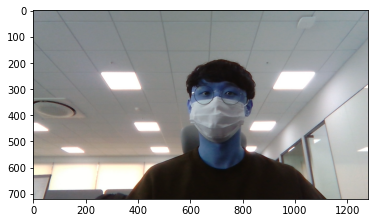

In [12]:
plt.imshow(img)

In [16]:
a = [[1,2,3,4],[5,6,7,8]]

In [15]:
detections[0]

tensor([3.0222e+02, 4.1652e+01, 1.1286e+03, 9.8126e+02, 9.9948e-01, 9.9999e-01,
        0.0000e+00])

In [22]:
plot_one_box(detections[0], img)

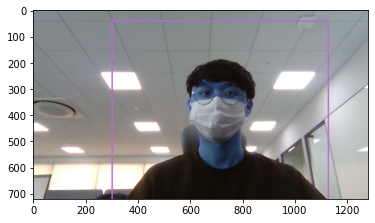

In [23]:
plt.imshow(img)

In [9]:
fig_img.shape

(288, 432, 4)